In [1]:
import numpy as np
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import time
import json
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras import backend as Keras

from sklearn import metrics
from scipy.spatial import distance

Using TensorFlow backend.


In [2]:
import os
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/')
import triplet

### Mine Triplets

In [3]:
CAFFE_ROOT = '/home/albert/caffe/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [4]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

In [5]:
test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

### Train Network

In [6]:
train_score = {}
test_score = {}

steps_per_epoch = 100

input_shape = (256,128)

overlay = False
overlay_eval = False
preprocess = True

# file_root = 'densenet_triplet_margin_preprocess_128x64'

False
False
0.603807926178


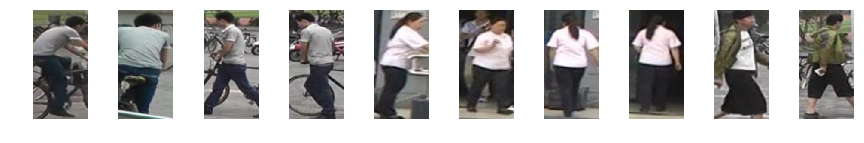

In [7]:
start = time.time()
batch = triplet.output_batch_generator(train_dict, train_labels,overlay=overlay, preprocess=False, 
                                                        shape=input_shape).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0][i].astype(np.uint8))
    plt.axis('off')
plt.show()

In [8]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

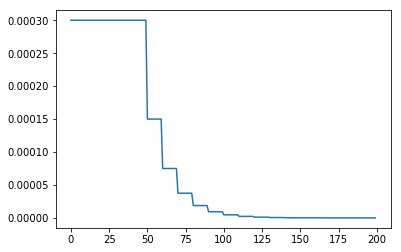

In [9]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [10]:
def plot_score(score):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    pos_distance = score['pos_distance']
    neg_distance = score['neg_distance']
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
    plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')

    plt.subplot(1,3,2)
    plt.plot(score['recall'], score['precision'])
    plt.xlabel('recall')
    plt.ylabel('precision')

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    
    plt.show()

    print score['rank']

In [11]:
input_margin = 0.5
P_param = 4
K_param = 4
input_output_dim = 128

def triplet_loss(y_pred, margin=input_margin, P=P_param, K=K_param, output_dim=input_output_dim):
    embeddings = tf.reshape(y_pred, (-1, output_dim))
    loss = tf.Variable(1, dtype=tf.float32)

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = tf.reduce_max(triplet.dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = tf.reduce_min(triplet.dist(pred_anchor, tf.concat([embeddings[0:i*K],
                                                                    embeddings[(i + 1)*K:]], 0)))
            if margin == None:
                loss += log1p(hard_pos - hard_neg)
            else:
                loss += tf.maximum(margin + hard_pos - hard_neg, 0.0)
    return loss

In [12]:
def output_batch_generator():
    files_dict = train_dict
    labels = train_labels
    P = P_param
    K = K_param
    shape = input_shape
    preprocess = False
    overlay = True
    
    batch = []
    idt_choice = np.random.choice(labels, P, replace=False)
    for p in range(len(idt_choice)):
        if K > len(files_dict[idt_choice[p]]):
            k_choice = np.random.choice(range(len(files_dict[idt_choice[p]])), K, replace=True)
        else:
            k_choice = np.random.choice(range(len(files_dict[idt_choice[p]])), K, replace=False)
        for k in k_choice:
            path = files_dict[idt_choice[p]][k]
            if overlay:
                batch.append(triplet.overlay_keypoints(path, shape=shape, train=True,
                                preprocess=preprocess).tolist())
            else:
                batch.append(triplet.imread_scale(path, shape=shape, preprocess=preprocess).tolist())
    return np.array(batch)

In [13]:
tf_input = tf.py_func(output_batch_generator, [], [tf.float64])

In [14]:
batch_size = 6
batch_input_shape = (16,256,128,3)
batch_inputs = tf.train.batch(tf_input, batch_size, shapes=[batch_input_shape])

In [15]:
batch_inputs

<tf.Tensor 'batch:0' shape=(6, 16, 256, 128, 3) dtype=float64>

In [16]:
base_model = densenet.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3))

base_model.outputs = [base_model.layers[-2].output]
base_model.layers[-1].outbound_nodes = []

x = base_model.outputs[0]
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
pred = Dense(128)(x)

Weights for the model were loaded successfully


In [17]:
model = Model(inputs=base_model.input, outputs=pred)

In [18]:
# https://blog.metaflow.fr/tensorflow-how-to-optimise-your-input-pipeline-with-queues-and-multi-threading-e7c3874157e0

q = tf.FIFOQueue(capacity=3, dtypes=tf.float64)

# batch_inputs = tf.Print(batch_inputs, data=[batch_inputs.shape[0]], 
#                         message="Raw inputs data generated:", summarize=7)
enqueue_op = q.enqueue_many(batch_inputs)

numberOfThreads = 16
qr = tf.train.QueueRunner(q, [enqueue_op] * numberOfThreads)
tf.train.add_queue_runner(qr) 

input = q.dequeue()
# input = tf.Print(input, data=[q.size(), input], message="Nb elements left, input:")

In [19]:
new_pred = model(input)

In [20]:
print new_pred

Tensor("model_1/dense_3/BiasAdd:0", shape=(?, 128), dtype=float32)


In [21]:
cost = tf.reduce_mean(triplet_loss(new_pred))

adam = tf.train.AdamOptimizer(learning_rate=0.0003, beta1=0.9, beta2=0.999, epsilon=1e-08)
train_step = adam.minimize(cost)

In [ ]:
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    disp_step = 100
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    start = time.time()
    for step in range(1,1001):        
        sess.run(train_step, feed_dict={'batch_normalization_1/keras_learning_phase:0' : True})
        
        if step % disp_step == 0:
            # Calculate batch loss and accuracy
            loss = sess.run(cost, feed_dict={'batch_normalization_1/keras_learning_phase:0' : True})
            print "Iter " + str(step) + ", Loss= " + "{:.6f}".format(loss)
            print time.time() - start
            start = time.time()

#     saver.save(sess, 'my_test_model', global_step=1000)

    coord.request_stop()
    coord.join(threads)

Iter 100, Loss= 110.206230
73.8920929432
Iter 200, Loss= 129.318024
68.3421318531
Iter 300, Loss= 85.663422
69.8388020992
Iter 400, Loss= 46.245602
69.1221680641
Iter 500, Loss= 50.551941
69.2969009876
